I used Men-Women Classification Datset From Kaggle
Link : https://www.kaggle.com/datasets/saadpd/menwomen-classification
this one used from transfer learning

In [2]:
import os , shutil, pathlib
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # hides INFO/WARNING logs from TF C++
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
# dataset_dir = r"/home/hamid/ML/Datasets/Men-Women/"
# num_train = len(os.listdir(dataset_dir + r"/traindata/traindata/men/"))

In [3]:
original_dir = pathlib.Path(r"/home/hamid/ML/Datasets/Men-Women/traindata/traindata/")
new_base_dir = pathlib.Path(r"/home/hamid/ML/Datasets/Men-Women-small")

In [4]:
def make_subset(subset_name , start_index, end_index):
    if (new_base_dir / subset_name).exists():
        shutil.rmtree(new_base_dir / subset_name)
    for category in ("men" , "women"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / category / fname , dst = dir / fname)
make_subset("train" , start_index = 0, end_index = 1000)
make_subset("validation" , start_index = 1000, end_index = 1200)
make_subset("test" , start_index = 1200, end_index = 1400)

In [5]:
train_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/train",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

validation_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/validation",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

test_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/test",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

Found 2000 files belonging to 2 classes.


I0000 00:00:1765036303.668331  224248 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5508 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [9]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet" ,
    include_top = False , 
    input_shape = (180 , 180 , 3)
)

In [10]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    # Unbatch and rebatch with smaller size
    dataset_unbatched = dataset.unbatch().batch(8)  # Use smaller batch size
    
    for images, labels in dataset_unbatched:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
    
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

I0000 00:00:1765036397.003032  224326 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
train_features.shape

(2000, 5, 5, 512)

In [16]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7800 - loss: 1.0219 - val_accuracy: 0.8175 - val_loss: 0.5821
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.3529 - val_accuracy: 0.8150 - val_loss: 0.5914
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9145 - loss: 0.2425 - val_accuracy: 0.8125 - val_loss: 0.5246
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9320 - loss: 0.1774 - val_accuracy: 0.8300 - val_loss: 0.4721
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 0.1213 - val_accuracy: 0.8350 - val_loss: 0.4706
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1057 - val_accuracy: 0.8300 - val_loss: 0.4701
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0779 - val_accuracy: 0.8225 - val_loss: 0.5318
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0495 - val_accuracy: 0.8275 - val_loss

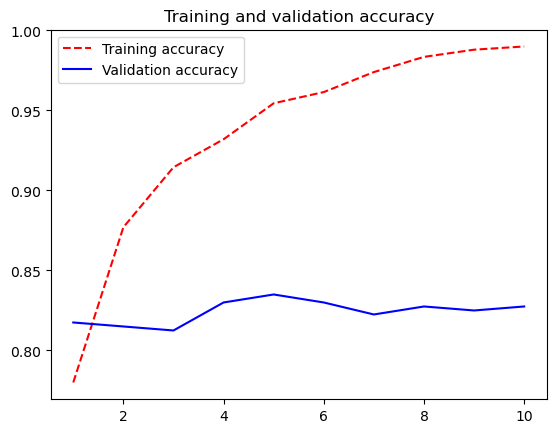

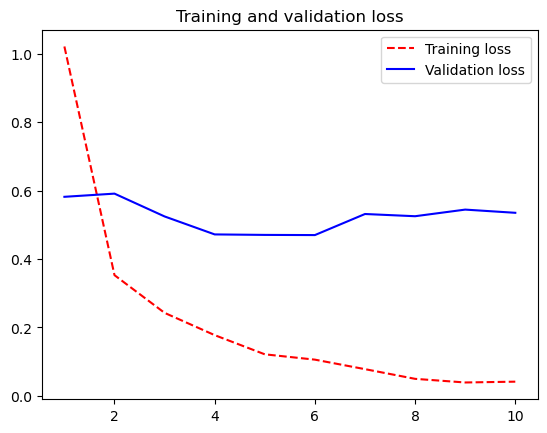

In [18]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8950 - loss: 0.3780
Test accuracy: 0.895
